## Housing Price - 3
- IInterpret the model results and make predictions

### Imports

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree


### Read in Data

In [2]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

Recreate Final Model

In [3]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [4]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

def rmse_log(y_true, y_pred):
    return np.mean(abs(np.log(y_true) - np.log(y_pred)))

In [5]:
model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=4,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=4,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [6]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))
print('Gradient Boosted Reduced Results: RMSE_log = %0.4f' % rmse_log(y_test, model_pred))

Final Model Performance on the test set: MAE = 15441.3164
Gradient Boosted Reduced Results: RMSE_log = 0.0886


# Interprete the Model

## Feature Importances

In [8]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the most important features keeping explained variance at 99%
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

importances = feature_results['importance']
threshold = .0
sel_feature = list()
for nf in range(len(importances)):
    if threshold <= 0.99:
        threshold += importances[nf]
        sel_feature.append(feature_results.loc[nf, 'feature'])
    else:
        break   
    
sel_feature, nf

(['OverallQual',
  'GarageArea',
  '2ndFlrSF',
  'TotalBsmtSF',
  'YearBuilt',
  '1stFlrSF',
  'LotArea',
  'Fireplaces',
  'YearRemodAdd',
  'BsmtFinSF1',
  'log_TotalBsmtSF',
  'OverallCond',
  'MasVnrArea',
  'MSZoning_RM',
  'OpenPorchSF',
  'BsmtQual_Ex',
  'BedroomAbvGr',
  'WoodDeckSF',
  'SaleCondition_Partial',
  'BsmtFinType1_GLQ',
  'BsmtExposure_Gd',
  'Id',
  'BsmtUnfSF',
  'MSZoning_RL',
  'Neighborhood_Crawfor',
  'MSSubClass_30',
  'LotFrontage',
  'MasVnrType_Stone',
  'MoSold',
  'Neighborhood_OldTown',
  'ScreenPorch',
  'YrSold',
  'log_BsmtUnfSF',
  'SaleCondition_Abnorml',
  'Exterior2nd_BrkFace',
  'BsmtFinSF2'],
 36)

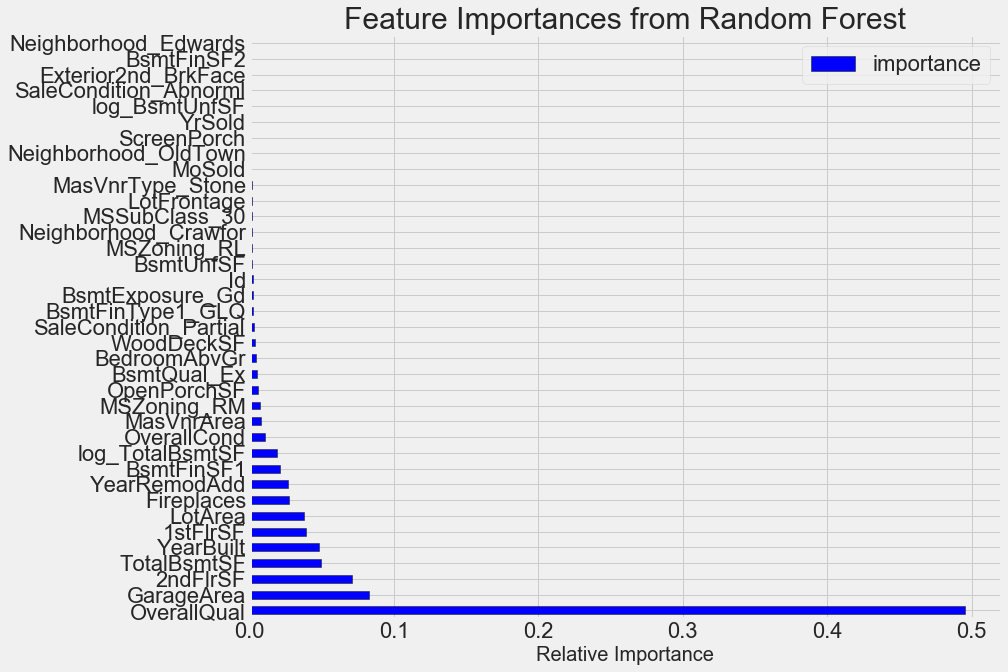

In [9]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:nf, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

## Use Feature Importances for Feature Selection

In [10]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:nf]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (1166, 36)
Most important testing  features shape:  (292, 36)


In [14]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))
#print('Linear Regression Reduced Results: RMSE_log = %0.4f' % rmse_log(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    22918.5307.
Linear Regression Reduced Results: MAE = 18302.6574.


In [15]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=4,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))
print('Gradient Boosted Reduced Results: RMSE_log = %0.4f' % rmse_log(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 15879.4367
Gradient Boosted Reduced Results: RMSE_log = 0.0911


## Prediction

In [24]:
target = pd.read_csv('data/no_price.csv')
target = target.drop(columns=['SalePrice'])

In [25]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X_target = imputer.transform(target)

In [26]:
#  Make predictions on the test set
model_pred = model.predict(X_target)

In [27]:
target['SalePrice'] = model_pred

In [28]:
submit = target[['Id','SalePrice']]
submit.head()

,Id,SalePrice
0,1461,122047.025949
1,1462,162553.427695
2,1463,179237.600487
3,1464,181363.246291
4,1465,191181.815435


In [29]:
submit.to_csv('data/submit.csv', index = False)